# Exploration of Candidate Data Mining Models, and Select the Final Model or Models


<b>Project Title:</b> Spotify Song Popularity Prediction


### Import Necessary Libraries:

In [ ]:
import os
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler


warnings.filterwarnings('ignore')

### Loading Data

In [ ]:
!wget 'https://rahul-public-datasets.s3.ap-south-1.amazonaws.com/song-prediction-data.zip'

--2024-04-16 02:23:11--  https://rahul-public-datasets.s3.ap-south-1.amazonaws.com/song-prediction-data.zip
Resolving rahul-public-datasets.s3.ap-south-1.amazonaws.com (rahul-public-datasets.s3.ap-south-1.amazonaws.com)... 52.219.160.134, 16.12.40.22, 52.219.158.26, ...
Connecting to rahul-public-datasets.s3.ap-south-1.amazonaws.com (rahul-public-datasets.s3.ap-south-1.amazonaws.com)|52.219.160.134|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1216068 (1.2M) [application/zip]
Saving to: ‘song-prediction-data.zip’

song-prediction-dat 100%[===================>]   1.16M   818KB/s    in 1.5s    

2024-04-16 02:23:14 (818 KB/s) - ‘song-prediction-data.zip’ saved [1216068/1216068]



In [ ]:
!unzip '/content/song-prediction-data.zip' -d '/content'

Archive:  /content/song-prediction-data.zip
  inflating: /content/song_data.csv  
  inflating: /content/__MACOSX/._song_data.csv  
  inflating: /content/song_info.csv  
  inflating: /content/__MACOSX/._song_info.csv  


In this problem, we will be making use of various attributes of songs on Spotify platform and estimating a given song's popularity. Hence the response variable will be `song_popularity` and rest of the attributes will be input variables. <br><br>From previous Data Exploration and Preparation Milestone, we found attributes like `song_duration_ms`, `key`, `audio_mode`, `speechiness` not don't contribute enough in estimating `song_popularity`. Hence we shall drop these attributes and select only the significant columns!

In [ ]:
k = pd.read_csv('/content/song_data.csv')
k.head(10)['song_name']

0    Boulevard of Broken Dreams
1                    In The End
2             Seven Nation Army
3                    By The Way
4             How You Remind Me
5              Bring Me To Life
6                   Last Resort
7      Are You Gonna Be My Girl
8                Mr. Brightside
9                   Sex on Fire
Name: song_name, dtype: object

In [ ]:
data = pd.read_csv('/content/song_data.csv')

data = data.drop(['song_name',
                  'song_duration_ms',
                  'key', 'audio_mode',
                  'speechiness'], axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18835 entries, 0 to 18834
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   song_popularity   18835 non-null  int64  
 1   acousticness      18835 non-null  float64
 2   danceability      18835 non-null  float64
 3   energy            18835 non-null  float64
 4   instrumentalness  18835 non-null  float64
 5   liveness          18835 non-null  float64
 6   loudness          18835 non-null  float64
 7   tempo             18835 non-null  float64
 8   time_signature    18835 non-null  int64  
 9   audio_valence     18835 non-null  float64
dtypes: float64(8), int64(2)
memory usage: 1.4 MB


### Data Preparation

Splitting the dataset and Normalising it further - Done in the Pt1 of the final code!

In [ ]:
train, test = train_test_split(data, test_size=0.15)
train, validation = train_test_split(train, test_size=0.15)
print(f'Number of samples in Train: {len(train)}, Validation: {len(validation)}, & Test: {len(test)}')

Xtrain, ytrain = train.drop('song_popularity', axis=1), train['song_popularity']
Xvalid, yvalid = validation.drop('song_popularity', axis=1), validation['song_popularity']
Xtest, ytest = test.drop('song_popularity', axis=1), test['song_popularity']

Number of samples in Train: 13607, Validation: 2402, & Test: 2826


In [ ]:
stdscalar = StandardScaler()
stdscalar.fit(Xtrain)
Xtrain_std = stdscalar.transform(Xtrain)
Xvalid_std = stdscalar.transform(Xvalid)
Xtest_std = stdscalar.transform(Xtest)

print(f'Data Dimensions - Train: {Xtrain.shape, ytrain.shape}, Validation: {Xvalid.shape, yvalid.shape}, Test: {Xtest.shape, ytest.shape}')

Data Dimensions - Train: ((13607, 9), (13607,)), Validation: ((2402, 9), (2402,)), Test: ((2826, 9), (2826,))


### Evaluation Criteria

In [ ]:
def compute_metrics(y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return {"r2": r2, "rmse": rmse}

In [ ]:
def plot_residuals(y_true, y_pred):
    residuals = y_true - y_pred
    plt.scatter(y_pred, residuals)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title('Residuals Plot')
    plt.show()

def plot_predictions(y_true, y_pred):
    plt.scatter(y_true, y_pred)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    plt.title('Predictions vs. True Values')
    plt.show()

### Model Exploration

#### Naive Regression Model

In [ ]:
class NaiveRegressor:
  def __init__(self):
    pass
  def fit(self, X, y):
    self.avg_y = np.mean(y)
  def predict(self, X):
    return np.array([self.avg_y]*len(X))

In [ ]:
nv_reg = NaiveRegressor()
nv_reg.fit(Xtrain_std, ytrain)

valid_preds_naive = nv_reg.predict(Xvalid_std)
valid_performance = compute_metrics(valid_preds_naive, yvalid)

print(f'Validation R2 Score: {valid_performance["r2"]}\nValidation RMSE: {valid_performance["rmse"]}')

Validation R2 Score: -9.507641501628345e+30
Validation RMSE: 21.909204175767073


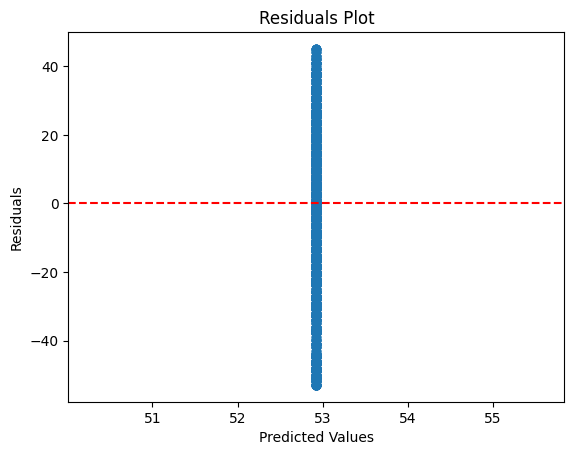

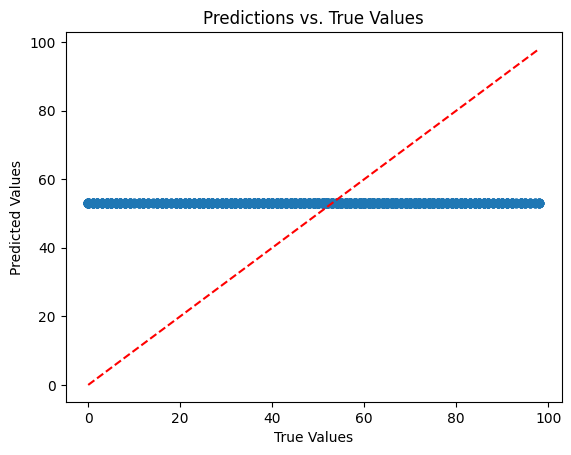

In [ ]:
# Visualize residuals and predictions
plot_residuals(yvalid, valid_preds_naive)
plot_predictions(yvalid, valid_preds_naive)

#### Linear Regression

From the Regression Analysis in previous Data Exploration Milestone, we found r-squared & adjusted r-squared to be only around 0.041 (4.1%). This indicates that the data we have have high non-linearity present and linear models will not be appropriate to capture the patterns. We repeat the Regression Analysis here to reiterate this point.

In [ ]:
X = sm.add_constant(Xtrain_std)
model = sm.OLS(ytrain, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:        song_popularity   R-squared:                       0.047
Model:                            OLS   Adj. R-squared:                  0.047
Method:                 Least Squares   F-statistic:                     74.85
Date:                Tue, 16 Apr 2024   Prob (F-statistic):          8.86e-136
Time:                        02:23:16   Log-Likelihood:                -60964.
No. Observations:               13607   AIC:                         1.219e+05
Df Residuals:                   13597   BIC:                         1.220e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         52.9258      0.183    288.969      0.0

Linear Regression - Validation MSE: 459.30542696879513
Linear Regression - Validation R2 Score: 0.04220408250284202


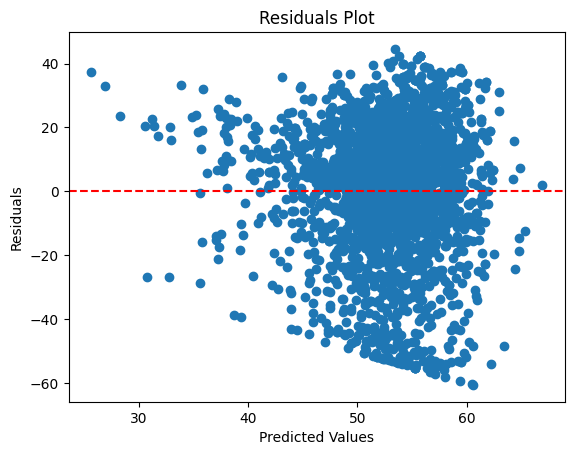

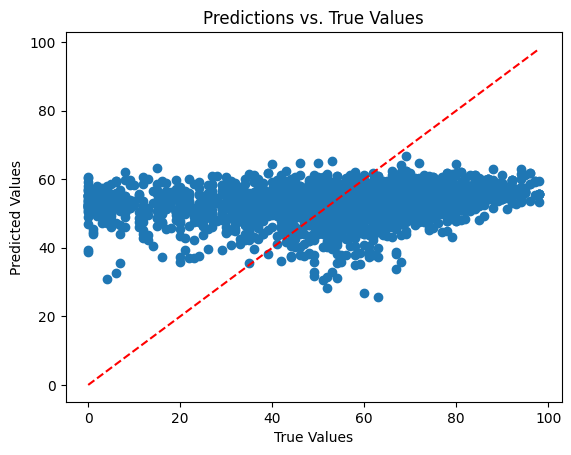

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

linear_reg = LinearRegression()
linear_reg.fit(Xtrain_std, ytrain)

valid_preds_linear = linear_reg.predict(Xvalid_std)
mse_linear = mean_squared_error(yvalid, valid_preds_linear)
r2_linear = r2_score(yvalid, valid_preds_linear)


print(f'Linear Regression - Validation MSE: {mse_linear}')
print(f'Linear Regression - Validation R2 Score: {r2_linear}')


plot_residuals(yvalid, valid_preds_linear)
plot_predictions(yvalid, valid_preds_linear)

**Observations**:
- The condition number is not too big. Indicating we have controlled the Multi-colinearlity.
- The Adjusted R-Square is 0.041 (4.1%) thereby indicating we were able to capture only 4% of the variance from the original data. This strongly suggests that data has high non-linearity present and linear models will not be enough to capture the patterns.

Moving forward we will be exploring non-linear models to capture intricate non-linear models in the data!

#### Decision Trees

In [ ]:
dt_reg = DecisionTreeRegressor()
dt_reg.fit(Xtrain_std, ytrain)

valid_preds_dt = dt_reg.predict(Xvalid_std)
valid_performance = compute_metrics(valid_preds_dt, yvalid)

print(f'Validation R2 Score: {valid_performance["r2"]}\nValidation RMSE: {valid_performance["rmse"]}')

Validation R2 Score: -0.13187848902686294
Validation RMSE: 23.2822412006209


In [ ]:
K_folds = 10
scores = cross_val_score(dt_reg,
                         Xtrain_std,
                         ytrain,
                         cv=K_folds, scoring='r2')
print(f'Mean R2 Score across {K_folds} Folds: {np.mean(scores)}')

Mean R2 Score across 10 Folds: -0.1804520734659416


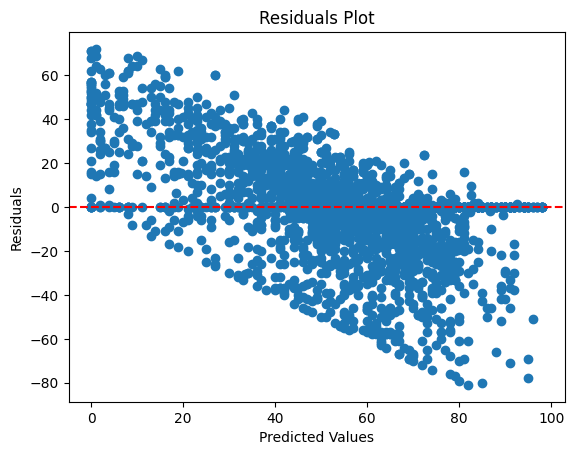

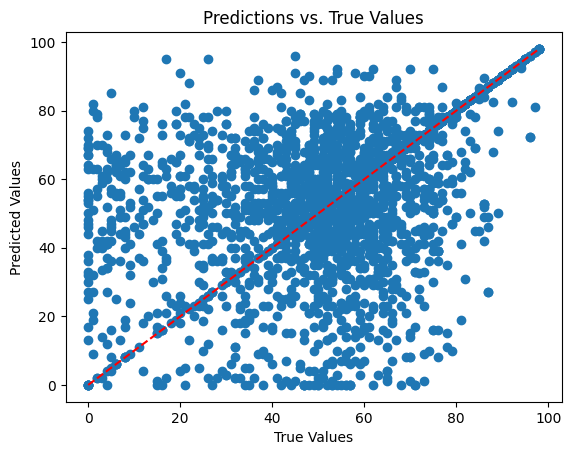

In [ ]:
# Visualize residuals and predictions
plot_residuals(yvalid, valid_preds_dt)
plot_predictions(yvalid, valid_preds_dt)


#### KNN Regressor

In [ ]:
knn_reg = KNeighborsRegressor(n_neighbors=100)
knn_reg.fit(Xtrain_std, ytrain)

valid_preds_knn = knn_reg.predict(Xvalid_std)
valid_performance = compute_metrics(valid_preds_knn, yvalid)

print(f'Validation R2 Score: {valid_performance["r2"]}\nValidation RMSE: {valid_performance["rmse"]}')

Validation R2 Score: -10.461405358922619
Validation RMSE: 21.053024811300766


In [ ]:
K_folds = 10
scores = cross_val_score(knn_reg,
                         Xtrain_std,
                         ytrain,
                         cv=K_folds, scoring='r2')
print(f'Mean R2 Score across {K_folds} Folds: {np.mean(scores)}')

Mean R2 Score across 10 Folds: 0.07916119329692181


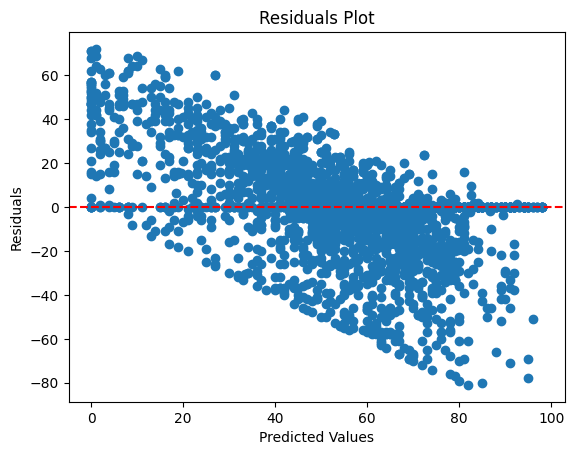

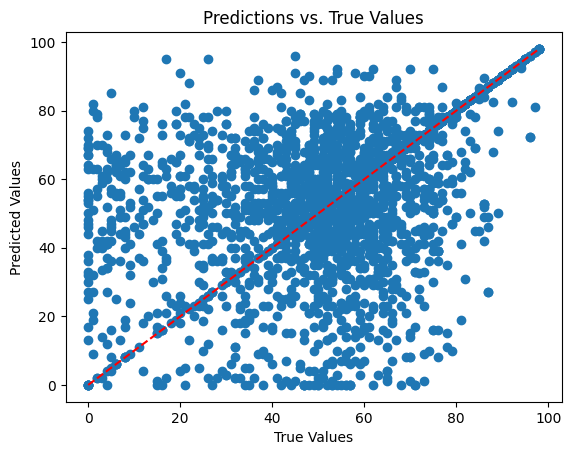

In [ ]:
plot_residuals(yvalid, valid_preds_dt)
plot_predictions(yvalid, valid_preds_dt)

#### Random Forest

In [ ]:
rf_reg = RandomForestRegressor(n_estimators=1000)
rf_reg.fit(Xtrain_std, ytrain)

valid_preds_rf = rf_reg.predict(Xvalid_std)
valid_performance = compute_metrics(valid_preds_rf, yvalid)

print(f'Validation R2 Score: {valid_performance["r2"]}\nValidation RMSE: {valid_performance["rmse"]}')

Validation R2 Score: -0.6680076338517829
Validation RMSE: 17.279762173300814


In [ ]:
K_folds = 10
scores = cross_val_score(rf_reg,
                         Xtrain_std,
                         ytrain,
                         cv=K_folds, scoring='r2')
print(f'Mean R2 Score across {K_folds} Folds: {np.mean(scores)}')

Mean R2 Score across 10 Folds: 0.3674227101867651


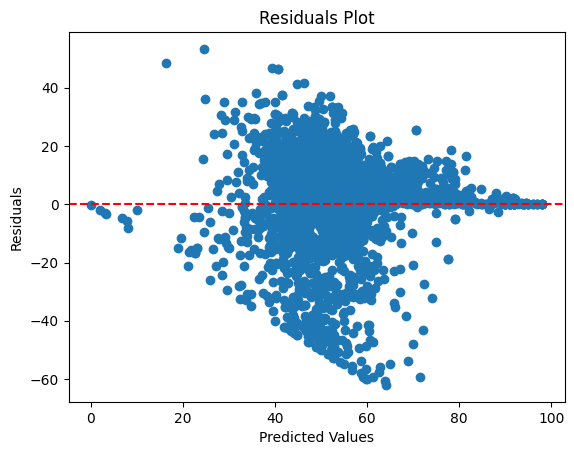

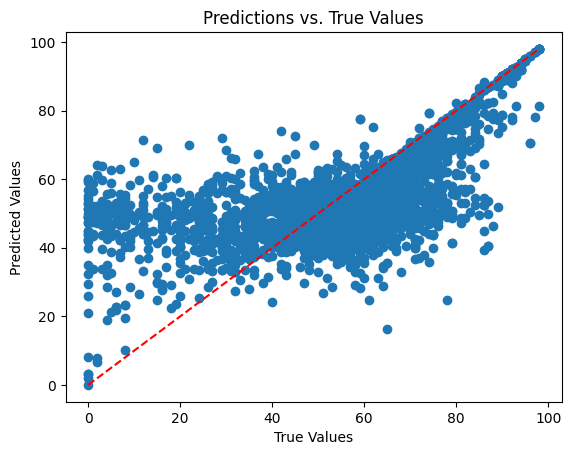

In [ ]:
# Visualize residuals and predictions
plot_residuals(yvalid, valid_preds_rf)
plot_predictions(yvalid, valid_preds_rf)

#### XGBoost

In [ ]:
xg_reg = xgb.XGBRegressor(n_estimators=1000)
xg_reg.fit(Xtrain_std, ytrain,
           eval_set=[(Xvalid_std, yvalid)],
           eval_metric="rmse",
           early_stopping_rounds=10)

valid_preds_xgb = xg_reg.predict(Xvalid_std)
valid_performance = compute_metrics(valid_preds_xgb, yvalid)

print(f'Validation R2 Score: {valid_performance["r2"]}\nValidation RMSE: {valid_performance["rmse"]}')

[0]	validation_0-rmse:21.40990
[1]	validation_0-rmse:21.07608
[2]	validation_0-rmse:20.86097
[3]	validation_0-rmse:20.75069
[4]	validation_0-rmse:20.66321
[5]	validation_0-rmse:20.56916
[6]	validation_0-rmse:20.46651
[7]	validation_0-rmse:20.45804
[8]	validation_0-rmse:20.40429
[9]	validation_0-rmse:20.37469
[10]	validation_0-rmse:20.31800
[11]	validation_0-rmse:20.23870
[12]	validation_0-rmse:20.20982
[13]	validation_0-rmse:20.16657
[14]	validation_0-rmse:20.15405
[15]	validation_0-rmse:20.10906
[16]	validation_0-rmse:20.06204
[17]	validation_0-rmse:20.05830
[18]	validation_0-rmse:20.07789
[19]	validation_0-rmse:20.06254
[20]	validation_0-rmse:20.01850
[21]	validation_0-rmse:19.98562
[22]	validation_0-rmse:20.00481
[23]	validation_0-rmse:19.98804
[24]	validation_0-rmse:19.96438
[25]	validation_0-rmse:19.95306
[26]	validation_0-rmse:19.91987
[27]	validation_0-rmse:19.91161
[28]	validation_0-rmse:19.89087
[29]	validation_0-rmse:19.89096
[30]	validation_0-rmse:19.88330
[31]	validation_0-

In [ ]:
K_folds = 10
scores = cross_val_score(xg_reg,
                         Xtrain_std,
                         ytrain,
                         cv=K_folds, scoring='r2', n_jobs=-1)
print(f'Mean R2 Score across {K_folds} Folds: {np.mean(scores)}')

Mean R2 Score across 10 Folds: 0.24687032984671312


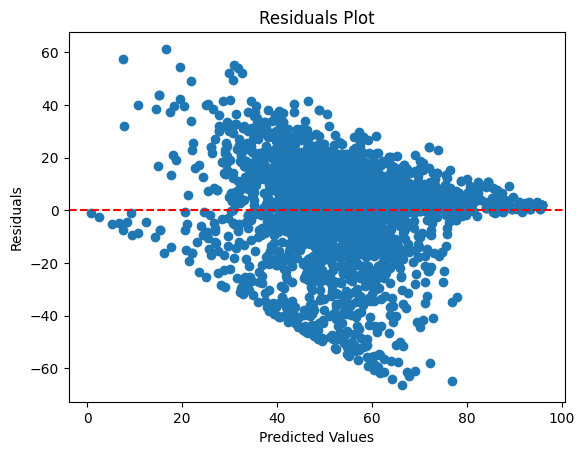

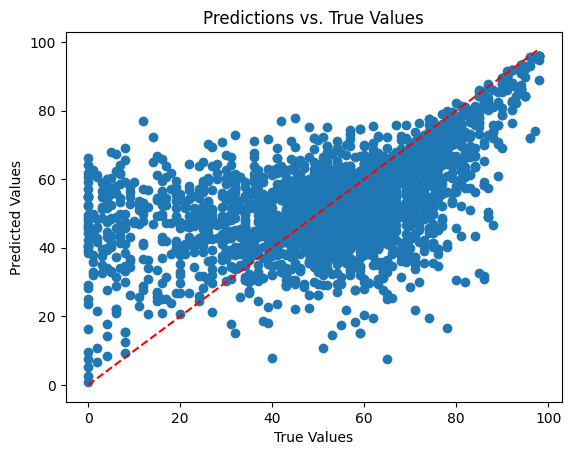

In [ ]:
# Visualize residuals and predictions
plot_residuals(yvalid, valid_preds_xgb)
plot_predictions(yvalid, valid_preds_xgb)

#### Gradient Boosting

In [ ]:
params = {'n_estimators': 1500,
          'max_depth': 5,
          'min_samples_split': 3,
          'min_samples_leaf': 2,
          'learning_rate': 0.01
         }
gbd_reg = GradientBoostingRegressor(**params)
gbd_reg.fit(Xtrain_std, ytrain)

valid_preds_gb = gbd_reg.predict(Xvalid_std)
valid_performance = compute_metrics(valid_preds_gb, yvalid)

print(f'Validation R2 Score: {valid_performance["r2"]}\nValidation RMSE: {valid_performance["rmse"]}')

Validation R2 Score: -4.324259098270602
Validation RMSE: 19.781816858220118


In [ ]:
K_folds = 10
scores = cross_val_score(gbd_reg,
                         Xtrain_std,
                         ytrain,
                         cv=K_folds, scoring='r2', n_jobs=-1)
print(f'Mean R2 Score across {K_folds} Folds: {np.mean(scores)}')

Mean R2 Score across 10 Folds: 0.19740848505478975


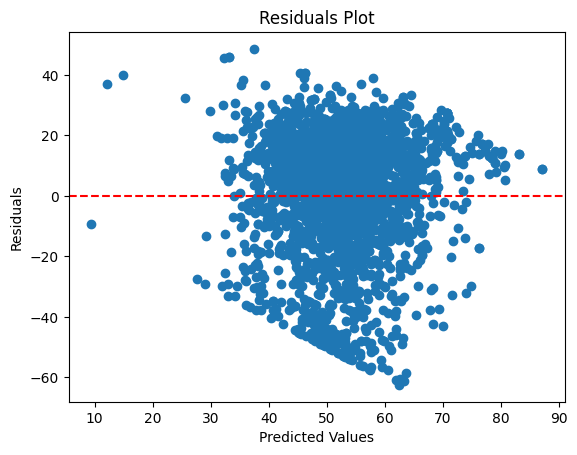

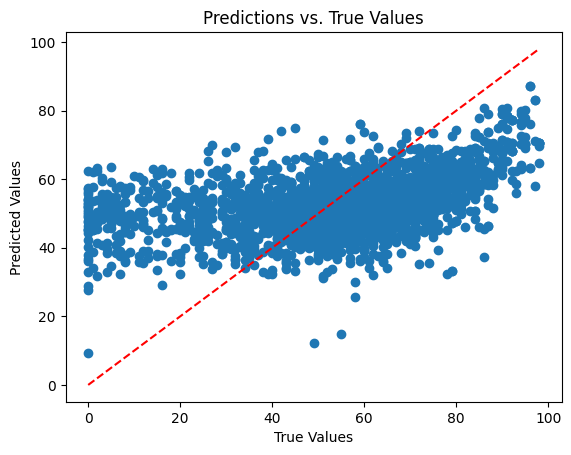

In [ ]:
# Visualize residuals and predictions
plot_residuals(yvalid, valid_preds_gb)
plot_predictions(yvalid, valid_preds_gb)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001498 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2045
[LightGBM] [Info] Number of data points in the train set: 13607, number of used features: 9
[LightGBM] [Info] Start training from score 52.925847
Validation R2 Score: 0.2959776063024786
Validation RMSE: 18.374161716342957


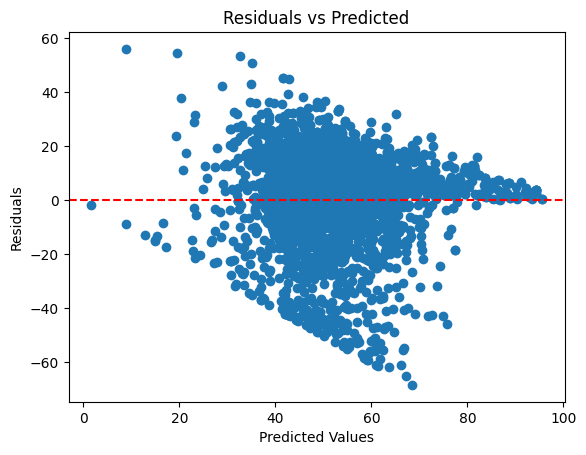

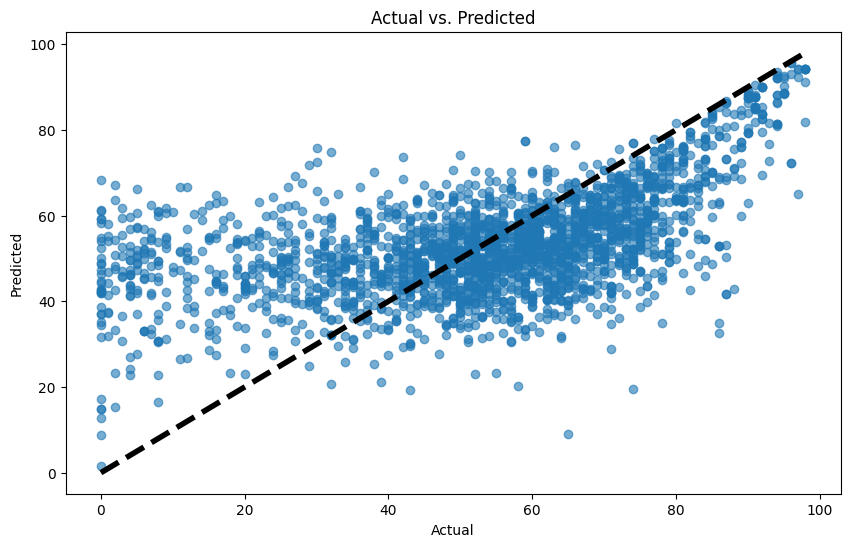

In [ ]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# Prepare the LightGBM datasets
dtrain = lgb.Dataset(Xtrain_std, label=ytrain)
dvalid = lgb.Dataset(Xvalid_std, label=yvalid)

# LightGBM parameters
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': ['l2', 'rmse'],
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5
}

# Train the model
bst = lgb.train(
    params,
    dtrain,
    num_boost_round=1000,
    valid_sets=[dvalid]
)

# Predict on the validation set
valid_preds_lgbm = bst.predict(Xvalid_std, num_iteration=bst.best_iteration)

# Compute metrics
valid_performance_lgbm = {
    'r2': r2_score(yvalid, valid_preds_lgbm),
    'rmse': np.sqrt(mean_squared_error(yvalid, valid_preds_lgbm))
}

print(f'Validation R2 Score: {valid_performance_lgbm["r2"]}')
print(f'Validation RMSE: {valid_performance_lgbm["rmse"]}')

# Visualize residuals
def plot_residuals(y_true, y_pred):
    residuals = y_true - y_pred
    plt.scatter(y_pred, residuals)
    plt.axhline(y=0, color='red', linestyle='--')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title('Residuals vs Predicted')
    plt.show()

# Visualize predictions
def plot_predictions(y_true, y_pred):
    plt.figure(figsize=(10, 6))
    plt.scatter(y_true, y_pred, alpha=0.6)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'k--', lw=4)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title('Actual vs. Predicted')
    plt.show()

# Plot residuals and predictions
plot_residuals(yvalid, valid_preds_lgbm)
plot_predictions(yvalid, valid_preds_lgbm)

Light GBM

In [ ]:
import numpy as np
from lightgbm import LGBMRegressor
from sklearn.model_selection import cross_val_score

# Initialize the LightGBM Regressor
lgbm_reg = LGBMRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    num_leaves=31,
    feature_fraction=0.9,
    bagging_fraction=0.8,
    bagging_freq=5,
    metric='rmse',
    boosting_type='gbdt',
    objective='regression'
)

# Number of folds for K-Fold Cross-Validation
K_folds = 10

# Perform the cross-validation
scores = cross_val_score(
    lgbm_reg,           # Model to test
    Xtrain_std,         # Feature matrix
    ytrain,             # Target vector
    cv=K_folds,         # Number of cross-validation folds
    scoring='r2',       # Scoring metric
    n_jobs=-1           # Use all CPU cores
)

# Calculate and print the mean R2 score across all folds
mean_r2_score = np.mean(scores)
print(f'Mean R2 Score across {K_folds} Folds: {mean_r2_score}')

Mean R2 Score across 10 Folds: 0.2892628474708448


SVM, RIDGE AND LASSO

Lasso Performance: {'r2': 0.04194599151602818, 'rmse': 21.434299451839035}
Ridge Performance: {'r2': 0.04220449914077318, 'rmse': 21.431407493968134}
SVM Performance: {'r2': 0.06434949931975387, 'rmse': 21.18220295283035}


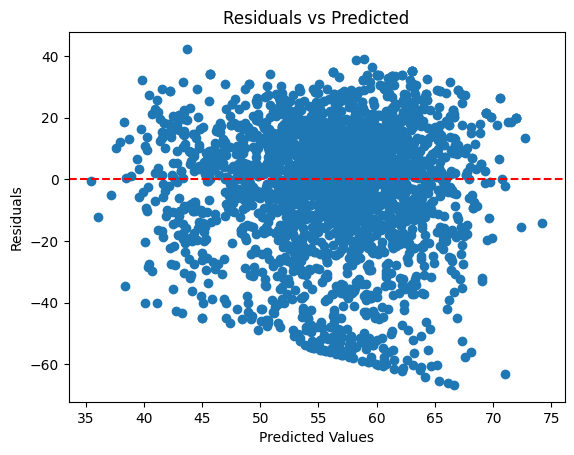

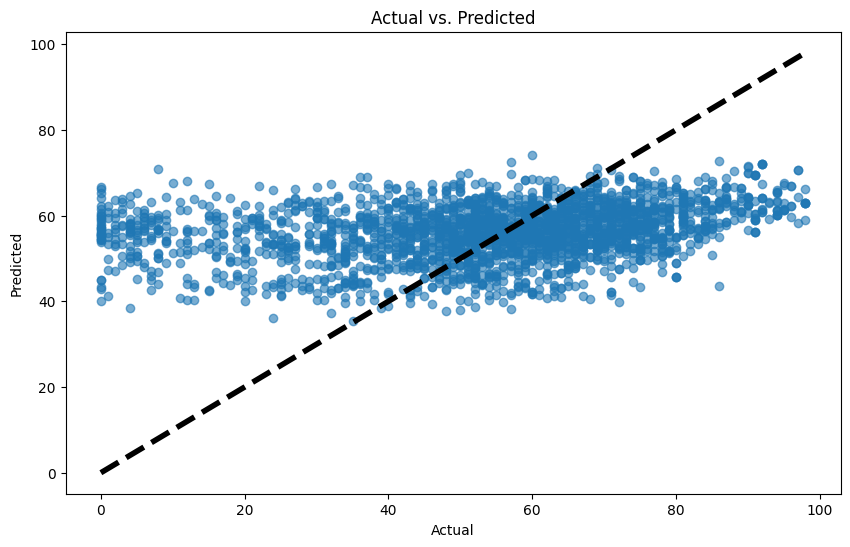

In [ ]:
from sklearn.linear_model import Lasso, Ridge
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# Define the models with optimal parameters (these should ideally be determined through cross-validation)
lasso_model = Lasso(alpha=0.1)
ridge_model = Ridge(alpha=1.0)
svm_model = SVR(C=1.0, kernel='rbf', gamma='scale')

# Fit the models
lasso_model.fit(Xtrain_std, ytrain)
ridge_model.fit(Xtrain_std, ytrain)
svm_model.fit(Xtrain_std, ytrain)

# Predict on the validation set
valid_preds_lasso = lasso_model.predict(Xvalid_std)
valid_preds_ridge = ridge_model.predict(Xvalid_std)
valid_preds_svm = svm_model.predict(Xvalid_std)

# Compute metrics
def compute_metrics(y_true, y_preds):
    return {
        'r2': r2_score(y_true, y_preds),
        'rmse': np.sqrt(mean_squared_error(y_true, y_preds))
    }

lasso_performance = compute_metrics(yvalid, valid_preds_lasso)
ridge_performance = compute_metrics(yvalid, valid_preds_ridge)
svm_performance = compute_metrics(yvalid, valid_preds_svm)

print("Lasso Performance:", lasso_performance)
print("Ridge Performance:", ridge_performance)
print("SVM Performance:", svm_performance)

# Functions to plot residuals and predictions (already defined)
def plot_residuals(y_true, y_pred):
    residuals = y_true - y_pred
    plt.scatter(y_pred, residuals)
    plt.axhline(y=0, color='red', linestyle='--')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title('Residuals vs Predicted')
    plt.show()

def plot_predictions(y_true, y_pred):
    plt.figure(figsize=(10, 6))
    plt.scatter(y_true, y_pred, alpha=0.6)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'k--', lw=4)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title('Actual vs. Predicted')
    plt.show()

# Visualize residuals and predictions for one of the models, for example, SVM
plot_residuals(yvalid, valid_preds_svm)
plot_predictions(yvalid, valid_preds_svm)

In [ ]:
from sklearn.model_selection import GridSearchCV

# Assuming Xtrain_std, ytrain are standardized training data and labels
# Define the parameter grids
param_grid_lasso = {'alpha': [0.001, 0.01, 0.1, 1, 10]}
param_grid_ridge = {'alpha': [0.001, 0.01, 0.1, 1, 10]}
param_grid_svm = {'C': [0.1, 1, 10, 100], 'kernel': ['linear', 'rbf'], 'gamma': ['scale', 'auto']}

# Setting up the GridSearchCV with K-Fold cross-validation for each model
lasso_grid = GridSearchCV(Lasso(), param_grid_lasso, cv=10, scoring='r2', verbose=1)
ridge_grid = GridSearchCV(Ridge(), param_grid_ridge, cv=10, scoring='r2', verbose=1)
svm_grid = GridSearchCV(SVR(), param_grid_svm, cv=10, scoring='r2', verbose=1)

# Fit the models using GridSearchCV
lasso_grid.fit(Xtrain_std, ytrain)
ridge_grid.fit(Xtrain_std, ytrain)
svm_grid.fit(Xtrain_std, ytrain)

# Extract the best estimator directly
lasso_model = lasso_grid.best_estimator_
ridge_model = ridge_grid.best_estimator_
svm_model = svm_grid.best_estimator_

# Predict on the validation set using the best found parameters
valid_preds_lasso = lasso_model.predict(Xvalid_std)
valid_preds_ridge = ridge_model.predict(Xvalid_std)
valid_preds_svm = svm_model.predict(Xvalid_std)

# Compute metrics
def compute_metrics(y_true, y_preds):
    return {
        'r2': r2_score(y_true, y_preds),
        'rmse': np.sqrt(mean_squared_error(y_true, y_preds))
    }

lasso_performance = compute_metrics(yvalid, valid_preds_lasso)
ridge_performance = compute_metrics(yvalid, valid_preds_ridge)
svm_performance = compute_metrics(yvalid, valid_preds_svm)

print("Lasso Best Parameters:", lasso_grid.best_params_)
print("Ridge Best Parameters:", ridge_grid.best_params_)
print("SVM Best Parameters:", svm_grid.best_params_)

print("Lasso Performance:", lasso_performance)
print("Ridge Performance:", ridge_performance)
print("SVM Performance:", svm_performance)

# Visualizations
plot_residuals(yvalid, valid_preds_svm)
plot_predictions(yvalid, valid_preds_svm)


In [ ]:
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Define models and their respective predictions
models = ['Naive', 'Linear Regression', 'Decision Tree', 'KNN Regressor', 'Random Forest', 'XGBoost', 'Gradient Boosting','Light GBM','Ridge','Lasso','SVM']
predictions = [valid_preds_naive, valid_preds_linear, valid_preds_dt, valid_preds_knn, valid_preds_rf, valid_preds_xgb, valid_preds_lgbm,valid_preds_ridge,valid_preds_lasso,valid_preds_svm ]

# Compute performance metrics for each model
mse = [mean_squared_error(yvalid, preds) for preds in predictions]
r2 = [r2_score(yvalid, preds) for preds in predictions]
rmse = [np.sqrt(m) for m in mse]  # Calculate RMSE

# Create a summary table
summary_table = pd.DataFrame({
    'Model': models,
    'MSE': mse,
    'RMSE': rmse,
    'R2 Score': r2
})

print(summary_table)


In [ ]:
# Train Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(Xtrain_std, ytrain)

# Predict popularity for validation set
y_pred_valid = rf_model.predict(Xvalid_std)

# Identify the most popular song
most_popular_index = y_pred_valid.argmax()
most_popular_song = k.iloc[most_popular_index]['song_name']
print(f"The most popular song is: {most_popular_song}")

# For example, let's visualize the distribution of song popularity
plt.figure(figsize=(10, 6))
plt.hist(k['song_popularity'], bins=20, color='skyblue')
plt.title('Distribution of Song Popularity')
plt.xlabel('Popularity')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [ ]:
top_n = 10  # Number of distinct top songs you want

# Sort the dataset by popularity in descending order
sorted_songs = k.sort_values(by='song_popularity', ascending=False)

# Extract distinct top songs
distinct_top_songs = sorted_songs.drop_duplicates(subset='song_popularity').head(top_n)

# Visualize the distinct top N popular songs
plt.figure(figsize=(10, 6))
sns.barplot(x='song_popularity', y='song_name', data=distinct_top_songs, palette='viridis')
plt.title(f'Distinct Top {top_n} Most Popular Songs')
plt.xlabel('Popularity')
plt.ylabel('Song Name')
plt.show()

In [ ]:
# Get distinct bottom N popular songs
bottom_n = 10  # Number of distinct bottom songs you want

# Sort the dataset by popularity in ascending order to get the least popular songs
sorted_songs = k.sort_values(by='song_popularity', ascending=True)

# Extract distinct bottom songs
distinct_bottom_songs = sorted_songs.drop_duplicates(subset='song_popularity').head(bottom_n)

# Visualize the distinct bottom N popular songs
plt.figure(figsize=(10, 6))
sns.barplot(x='song_popularity', y='song_name', data=distinct_bottom_songs, palette='viridis')
plt.title(f'Distinct Bottom {bottom_n} Least Popular Songs')
plt.xlabel('Popularity')
plt.ylabel('Song Name')
plt.show()